# xG vs actual goals

In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.text as mtext
from matplotlib.offsetbox import AnchoredText
import numpy as np

from PIL import Image
import urllib
import json
import os

# Read data into dataframes to manipulate

In [335]:
path_to_json_matches = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\matchdata' 
path_to_json_minutesdata = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\playerdata'

# find all .json extensions in a specific directory and assign to one of two lists (matches, players)
json_files_matches = [pos_json for pos_json in os.listdir(path_to_json_matches) if pos_json.endswith('.json')]
json_file_minutesdata = [pos_json for pos_json in os.listdir(path_to_json_minutesdata) if pos_json.endswith('.json')]

In [336]:
# Collect all matches from directory in a dataframe
all_matches = []

for i in list(range(0, len(json_files_matches))):
    file_path = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\matchdata' + '/' + json_files_matches[i]
    with open(file_path) as file:
        data = json.load(file)
        match_date = data['date']  # Extract the date for the current match
        events = data['events']  # Extract the events for the current match
        for event in events:
            event['date'] = pd.to_datetime(match_date).date().isoformat()  # Transform to year-month-day format
        all_matches.extend(events)  # Append the modified events to the list

all_matches_df = pd.DataFrame(all_matches)  # Convert the list of dictionaries to DataFrame


# Collect the ID for a specific tournament and match
dir = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\playerdata'
f = open (dir + '/' + json_file_minutesdata[0])
minutesdata = json.loads(f.read())
minutesdata = pd.DataFrame(minutesdata)

# Ensure full player names are present (e.g. "A. Murray" becomes "Andy Murray)

In [338]:
# rename the minutesdata name column to player
minutesdata = minutesdata.rename(columns={'name': 'player'})
# Create a dictionary to map nicknames to player names, excluding None or Null 'friendly_name'
nickname_map = minutesdata.dropna(subset=['friendly_name']).set_index('friendly_name')['player'].to_dict()

# Replace nicknames with player names in all_matches_df only if 'friendly_name' is not None or NULL
all_matches_df['player'] = all_matches_df.apply(lambda row: nickname_map.get(row['player']) if row['player'] in nickname_map else row['player'], axis=1)

# Drop records without "xg" values. Create two dfs from goals and shots

In [339]:
all_matches_df = all_matches_df.dropna(subset=['xg'])
goal_df = all_matches_df[all_matches_df['action'] == 'Goal']
shot_df = all_matches_df[all_matches_df['action'] == 'Shot']

# Sum up the goals + xg and calculate the difference

In [340]:
# From the goal_df we sum up the total amount of goals, and then the xg from each goal
# From the shot_df we sum up the total xg from each shot

# Calculate the sum of goals for each player, team, and date
goals_sum = goal_df.groupby(['player', 'team', 'date'])['action'].count().reset_index()
goals_sum.rename(columns={'action': 'goals'}, inplace=True)

# Calculate the sum of xG from goals for each player, team, and date
xg_goals_sum = goal_df.groupby(['player', 'team', 'date'])['xg'].sum().reset_index()
xg_goals_sum.rename(columns={'xg': 'xg_goals'}, inplace=True)

# Calculate the sum of xG from shots for each player, team, and date
xg_shots_sum = shot_df.groupby(['player', 'team', 'date'])['xg'].sum().reset_index()
xg_shots_sum.rename(columns={'xg': 'xg_shots'}, inplace=True)

# Merge the calculated sums into the player_df
player_df = pd.merge(goals_sum, xg_goals_sum, on=['player', 'team', 'date'], how='outer')
player_df = pd.merge(player_df, xg_shots_sum, on=['player', 'team', 'date'], how='outer')

# Drop all NaN-values
player_df.fillna(0, inplace=True)

# Create an 'xG' column that is the sum of 'xg_goals' and 'xg_shots'
player_df['xG'] = player_df['xg_goals'] + player_df['xg_shots'] 

# Calculate the difference between 'goals' and 'xG'
player_df['difference'] = player_df['goals'] - player_df['xG']
player_df.sort_values(by='difference', ascending=False)

,player,team,date,goals,xg_goals,xg_shots,xG,difference
339,Noel Wågberg,IFK Stocksund,2023-05-12,3.0,0.271082,0.000000,0.271082,2.728918
346,Oliver Åkerman,Eskilsminne IF,2023-06-11,3.0,0.548139,0.179567,0.727707,2.272293
152,Erik Björndahl,IF Karlstad Fotboll,2023-04-16,2.0,0.121081,0.000000,0.121081,1.878919
51,Alibek Aliev,Trollhättan,2023-05-07,2.0,0.189182,0.000000,0.189182,1.810818
170,Fredrik Johansson,Piteå IF FF,2023-05-13,2.0,0.202437,0.012157,0.214594,1.785406
...,...,...,...,...,...,...,...,...
1389,Johan Albin,Eskilsminne IF,2023-06-05,0.0,0.000000,1.127868,1.127868,-1.127868
2404,Wanbe Godwin Aguda,Falkenbergs FF,2023-05-01,0.0,0.000000,1.136321,1.136321,-1.136321
2187,Samuel Dawid Rydz,Täby FK,2023-05-12,0.0,0.000000,1.145362,1.145362,-1.145362
6,Abdulmannan Khalil,Sollentuna FK,2023-05-18,1.0,0.411697,1.744572,2.156269,-1.156269


# Sum up xG, goals, and the difference for a player in a specific team

In [353]:
sum_diff_player_df_1 = player_df.groupby(['player', 'team'])['difference'].sum().reset_index()
sum_goals_player_df_1 = player_df.groupby(['player', 'team'])['goals'].sum().reset_index()
sum_xg_player_df_1 = player_df.groupby(['player', 'team'])['xG'].sum().reset_index()
sum_diff_player_df = sum_diff_player_df_1.merge(sum_goals_player_df_1, on=['player', 'team'])
sum_diff_player_df = sum_diff_player_df.merge(sum_xg_player_df_1, on=['player', 'team'])

# function that takes the timeline of xG and actual goals so we can plot a time series.

In [350]:
def get_player_goals_xg_df(player, data=player_df):
    df = data.copy()
    player_data = df[df['player'] == player][['player', 'team', 'date', 'goals', 'xG']].reset_index(drop=True)
    player_data.columns = ['player', 'team', 'date', 'goals', 'xG']
    player_data['cum_goals'] = player_data['goals'].cumsum()
    player_data['cum_xG'] = player_data['xG'].cumsum()
    player_data['cum_difference'] = player_data['cum_goals'] - player_data['cum_xG']
    return player_data


# The viz

In [351]:
def plot_goals_difference(ax, player, label_y = False, data=player_df):
    ax.grid(ls='--', color='lightgrey')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linestyle('dashed')
    ax.tick_params(color='lightgrey', labelsize=8, labelcolor='grey')
    test_df = get_player_goals_xg_df(player, data)

    ax.plot(test_df.index + 1, test_df['cum_goals'], marker='o', mfc='white', ms=5, color='#287271')
    ax.plot(test_df.index + 1, test_df['cum_xG'], marker='o', mfc='white', ms=5, color='#D81159')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_ylim(-1,13)
    ax.set_xlim(0.25)
    ax.set_xticklabels([])
    # Determine a reference mid-point and the difference between xG and goals
    mid_point = test_df['cum_goals'].iloc[-1] + (test_df['cum_xG'].iloc[-1] - test_df['cum_goals'].iloc[-1])/2
    difference = test_df['cum_goals'].iloc[-1] - test_df['cum_xG'].iloc[-1]
    text_ = ax.annotate(
    xy=(ax.get_xlim()[1], mid_point),
    text=f'{difference:.1f}',
    xytext=(-5,0),
    ha='center',
    va='center',
    color='#D81159',
    weight='bold',
    size=7,
    textcoords='offset points'
    )
    text_.set_path_effects(
    [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )
    # ----------------------------------------------------------------
    if label_y:
        ax.set_ylabel('Goals', color='grey', size=8)
    else:
        ax.set_yticklabels([])

# Plot for players with xG > goals

Cumulative xG for Alibek Aliev: 5.7
Cumulative goals for Alibek Aliev: 13
Cumulative xG for Deniz Gül: 4.1
Cumulative goals for Deniz Gül: 8
Cumulative xG for Zinedin Smajlovic: 1.3
Cumulative goals for Zinedin Smajlovic: 5
Cumulative xG for Aron Sandén: 1.7
Cumulative goals for Aron Sandén: 5
Plotting graph for Alibek Aliev (Trollhättan)
Plotting graph for Deniz Gül (Hammarby TFF Herrfotboll)
Plotting graph for Zinedin Smajlovic (Täby FK)
Plotting graph for Aron Sandén (Sollentuna FK)
Cumulative xG for Oliver Åkerman: 1.8
Cumulative goals for Oliver Åkerman: 5
Cumulative xG for Wanbe Godwin Aguda: 4.1
Cumulative goals for Wanbe Godwin Aguda: 7
Cumulative xG for Rasmus Andersson: 2.6
Cumulative goals for Rasmus Andersson: 5
Cumulative xG for Richard Cindric: 1.6
Cumulative goals for Richard Cindric: 4
Plotting graph for Oliver Åkerman (Eskilsminne IF)
Plotting graph for Wanbe Godwin Aguda (Falkenbergs FF)
Plotting graph for Rasmus Andersson (Tvååkers IF)
Plotting graph for Richard Cind

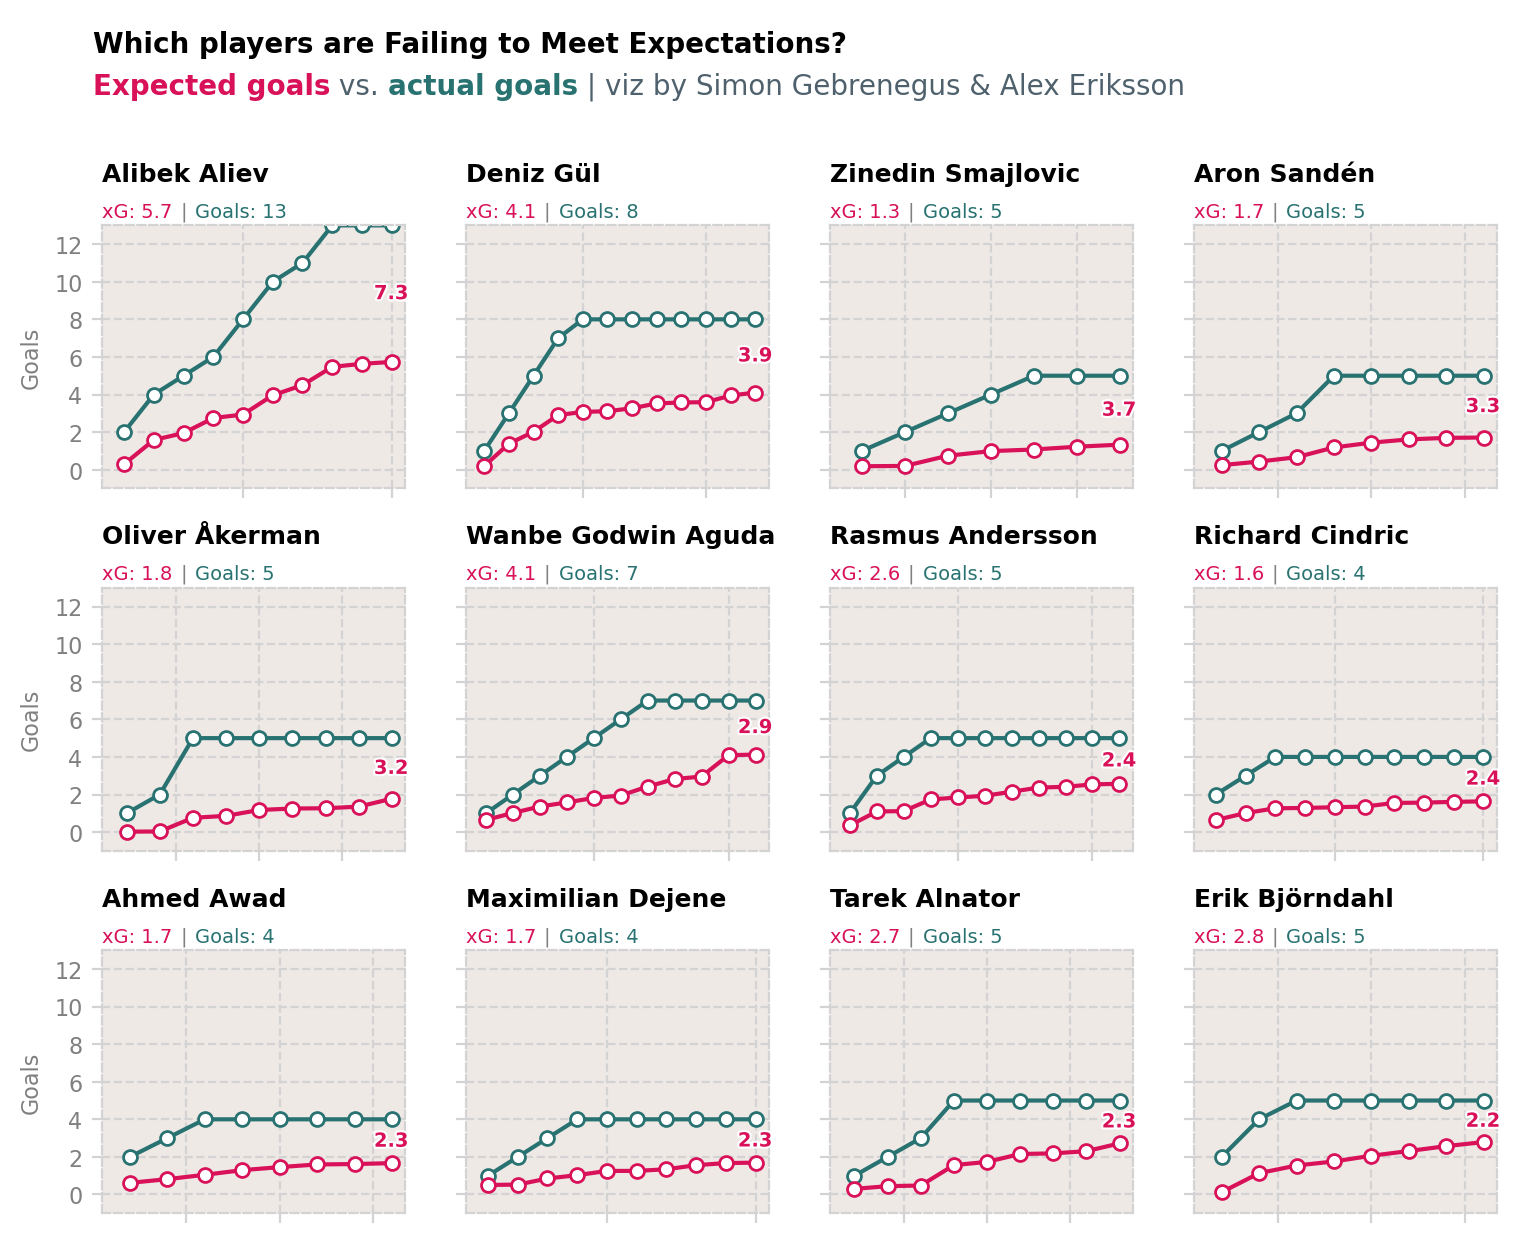

In [352]:
fig = plt.figure(figsize=(9, 7), dpi=200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1 / nrows) * 2.6 if x % 2 != 0 else (1 / nrows) / 2.6 for x in range(nrows)], hspace=0.2
)

# Choose the top 12 players based on the difference column
top_players = sum_diff_player_df.nlargest(12, 'difference')

# INSERT PLAYERS TO CHOOSE FROM LIST HERE
chosen_players = top_players['player'].tolist()

plot_counter = 0
name_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor="#EFE9E6"
            )
            if plot_counter < len(chosen_players):
                player = chosen_players[plot_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    label_y = col == 0
                    print(f"Plotting graph for {player} ({team})")
                    plot_goals_difference(ax, player, label_y, data=filtered_df)
                    plot_counter += 1
        else:
            if name_counter < len(chosen_players):
                player = chosen_players[name_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    xgoals = filtered_df.iloc[-1]['xG']
                    agoals = filtered_df.iloc[-1]['goals']
                    name_ax = plt.subplot(
                        gspec[row, col],
                        anchor='NW', facecolor='#EFE9E6'
                    )
                    name_ax.axis('off')

                    cumulative_xg = filtered_df['xG'].sum()
                    cumulative_goals = filtered_df['goals'].sum()
                    print(f"Cumulative xG for {player}: {cumulative_xg:.1f}")
                    print(f"Cumulative goals for {player}: {cumulative_goals:.0f}")
                    
                    ax_text(
                        x=0,  # Adjust this value to position the text closer to the graph
                        y=0.85,
                        s=f'<{player}>\n<xG: {cumulative_xg:.1f}> <|> <Goals: {cumulative_goals:.0f}>',
                        ax=name_ax,
                        highlight_textprops=[{'weight': 'bold', 'font': 'DM Sans'},
                                             {'size': '7', 'color': '#D81159'},
                                             {'size': '7', 'color': 'grey'},
                                             {'size': '7', 'color': '#287271'}],
                        font='Karla',
                        ha='left',
                        size=9,
                        annotationbbox_kw={'xycoords': 'axes fraction'}
                    )
                    name_counter += 1

fig_text(
    x=0.12, y=.95,
    s='Which players are Failing to Meet Expectations?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
    x=0.12, y=.92,
    s='<Expected goals> vs. <actual goals> | viz by Simon Gebrenegus & Alex Eriksson',
    highlight_textprops=[{'weight': 'bold', 'color': '#D81159'}, {'weight': 'bold', 'color': '#287271'}],
    va='bottom', ha='left',
    fontsize=8, color='#4E616C', font='Karla'
)

plt.savefig(
    r'C:\Users\al.eriksson\Documents\Python\Football\xg_bigger_goals',
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

plt.show()

# Plot for players with goals > xG

Cumulative xG for Majkel Bagir: 5.8
Cumulative goals for Majkel Bagir: 3
Cumulative xG for Nobel Tesfazgyi Gebrezgi: 2.1
Cumulative goals for Nobel Tesfazgyi Gebrezgi: 0
Cumulative xG for Hampus Stoltz: 2.9
Cumulative goals for Hampus Stoltz: 1
Cumulative xG for Hampus Ferhm: 1.9
Cumulative goals for Hampus Ferhm: 0
Plotting graph for Majkel Bagir (IFK Stocksund)
Plotting graph for Nobel Tesfazgyi Gebrezgi (Hammarby TFF Herrfotboll)
Plotting graph for Hampus Stoltz (Eskilsminne IF)
Plotting graph for Hampus Ferhm (Torns IF)
Cumulative xG for Nicolas Gianini Dantas: 1.8
Cumulative goals for Nicolas Gianini Dantas: 0
Cumulative xG for Declan Watters: 1.8
Cumulative goals for Declan Watters: 0
Cumulative xG for Ayomide Jibodu: 2.7
Cumulative goals for Ayomide Jibodu: 1
Cumulative xG for Max Andersson: 1.7
Cumulative goals for Max Andersson: 0
Plotting graph for Nicolas Gianini Dantas (Oskarshamns AIK)
Plotting graph for Declan Watters (Vänersborgs IF)
Plotting graph for Ayomide Jibodu (Os

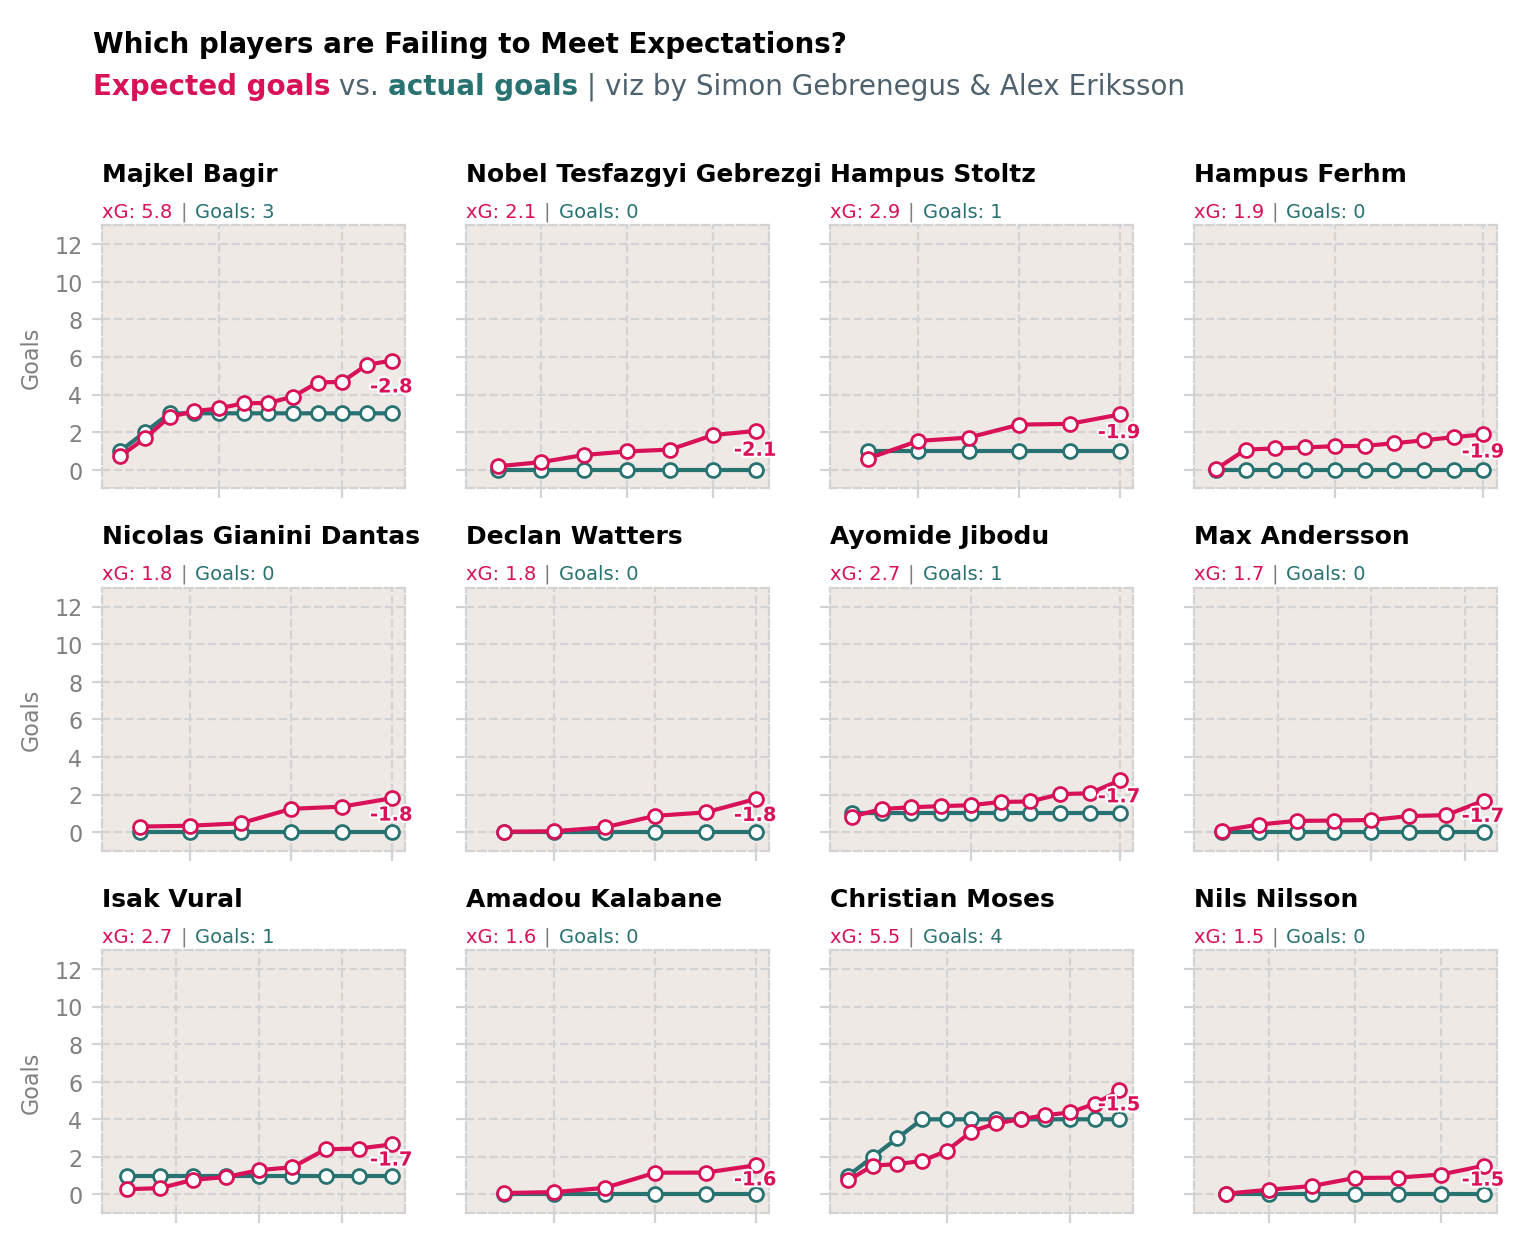

In [348]:
fig = plt.figure(figsize=(9, 7), dpi=200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1 / nrows) * 2.6 if x % 2 != 0 else (1 / nrows) / 2.6 for x in range(nrows)], hspace=0.2
)

# Choose the top 12 players based on the difference column in descending order
top_players = sum_diff_player_df.nsmallest(12, 'difference')

# INSERT PLAYERS TO CHOOSE FROM LIST HERE
chosen_players = top_players['player'].tolist()

plot_counter = 0
name_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor="#EFE9E6"
            )
            if plot_counter < len(chosen_players):
                player = chosen_players[plot_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    label_y = col == 0
                    print(f"Plotting graph for {player} ({team})")
                    plot_goals_difference(ax, player, label_y, data=filtered_df)
                    plot_counter += 1
        else:
            if name_counter < len(chosen_players):
                player = chosen_players[name_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    xgoals = filtered_df.iloc[-1]['xG']
                    agoals = filtered_df.iloc[-1]['goals']
                    name_ax = plt.subplot(
                        gspec[row, col],
                        anchor='NW', facecolor='#EFE9E6'
                    )
                    name_ax.axis('off')

                    cumulative_xg = filtered_df['xG'].sum()
                    cumulative_goals = filtered_df['goals'].sum()
                    print(f"Cumulative xG for {player}: {cumulative_xg:.1f}")
                    print(f"Cumulative goals for {player}: {cumulative_goals:.0f}")
                    
                    ax_text(
                        x=0,  # Adjust this value to position the text closer to the graph
                        y=0.85,
                        s=f'<{player}>\n<xG: {cumulative_xg:.1f}> <|> <Goals: {cumulative_goals:.0f}>',
                        ax=name_ax,
                        highlight_textprops=[{'weight': 'bold', 'font': 'DM Sans'},
                                             {'size': '7', 'color': '#D81159'},
                                             {'size': '7', 'color': 'grey'},
                                             {'size': '7', 'color': '#287271'}],
                        font='Karla',
                        ha='left',
                        size=9,
                        annotationbbox_kw={'xycoords': 'axes fraction'}
                    )
                    name_counter += 1

fig_text(
    x=0.12, y=.95,
    s='Which players are Failing to Meet Expectations?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
    x=0.12, y=.92,
    s='<Expected goals> vs. <actual goals> | viz by Simon Gebrenegus & Alex Eriksson',
    highlight_textprops=[{'weight': 'bold', 'color': '#D81159'}, {'weight': 'bold', 'color': '#287271'}],
    va='bottom', ha='left',
    fontsize=8, color='#4E616C', font='Karla'
)

plt.savefig(
    r'C:\Users\al.eriksson\Documents\Python\Football\goals_bigger_xg',
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

plt.show()


# goals > xG | more than 2 goals scored or more than 2 xG

Cumulative xG for Alibek Aliev: 5.7
Cumulative goals for Alibek Aliev: 13
Cumulative xG for Deniz Gül: 4.1
Cumulative goals for Deniz Gül: 8
Cumulative xG for Zinedin Smajlovic: 1.3
Cumulative goals for Zinedin Smajlovic: 5
Cumulative xG for Aron Sandén: 1.7
Cumulative goals for Aron Sandén: 5
Plotting graph for Alibek Aliev (Trollhättan)
Plotting graph for Deniz Gül (Hammarby TFF Herrfotboll)
Plotting graph for Zinedin Smajlovic (Täby FK)
Plotting graph for Aron Sandén (Sollentuna FK)
Cumulative xG for Oliver Åkerman: 1.8
Cumulative goals for Oliver Åkerman: 5
Cumulative xG for Wanbe Godwin Aguda: 4.1
Cumulative goals for Wanbe Godwin Aguda: 7
Cumulative xG for Rasmus Andersson: 2.6
Cumulative goals for Rasmus Andersson: 5
Cumulative xG for Richard Cindric: 1.6
Cumulative goals for Richard Cindric: 4
Plotting graph for Oliver Åkerman (Eskilsminne IF)
Plotting graph for Wanbe Godwin Aguda (Falkenbergs FF)
Plotting graph for Rasmus Andersson (Tvååkers IF)
Plotting graph for Richard Cind

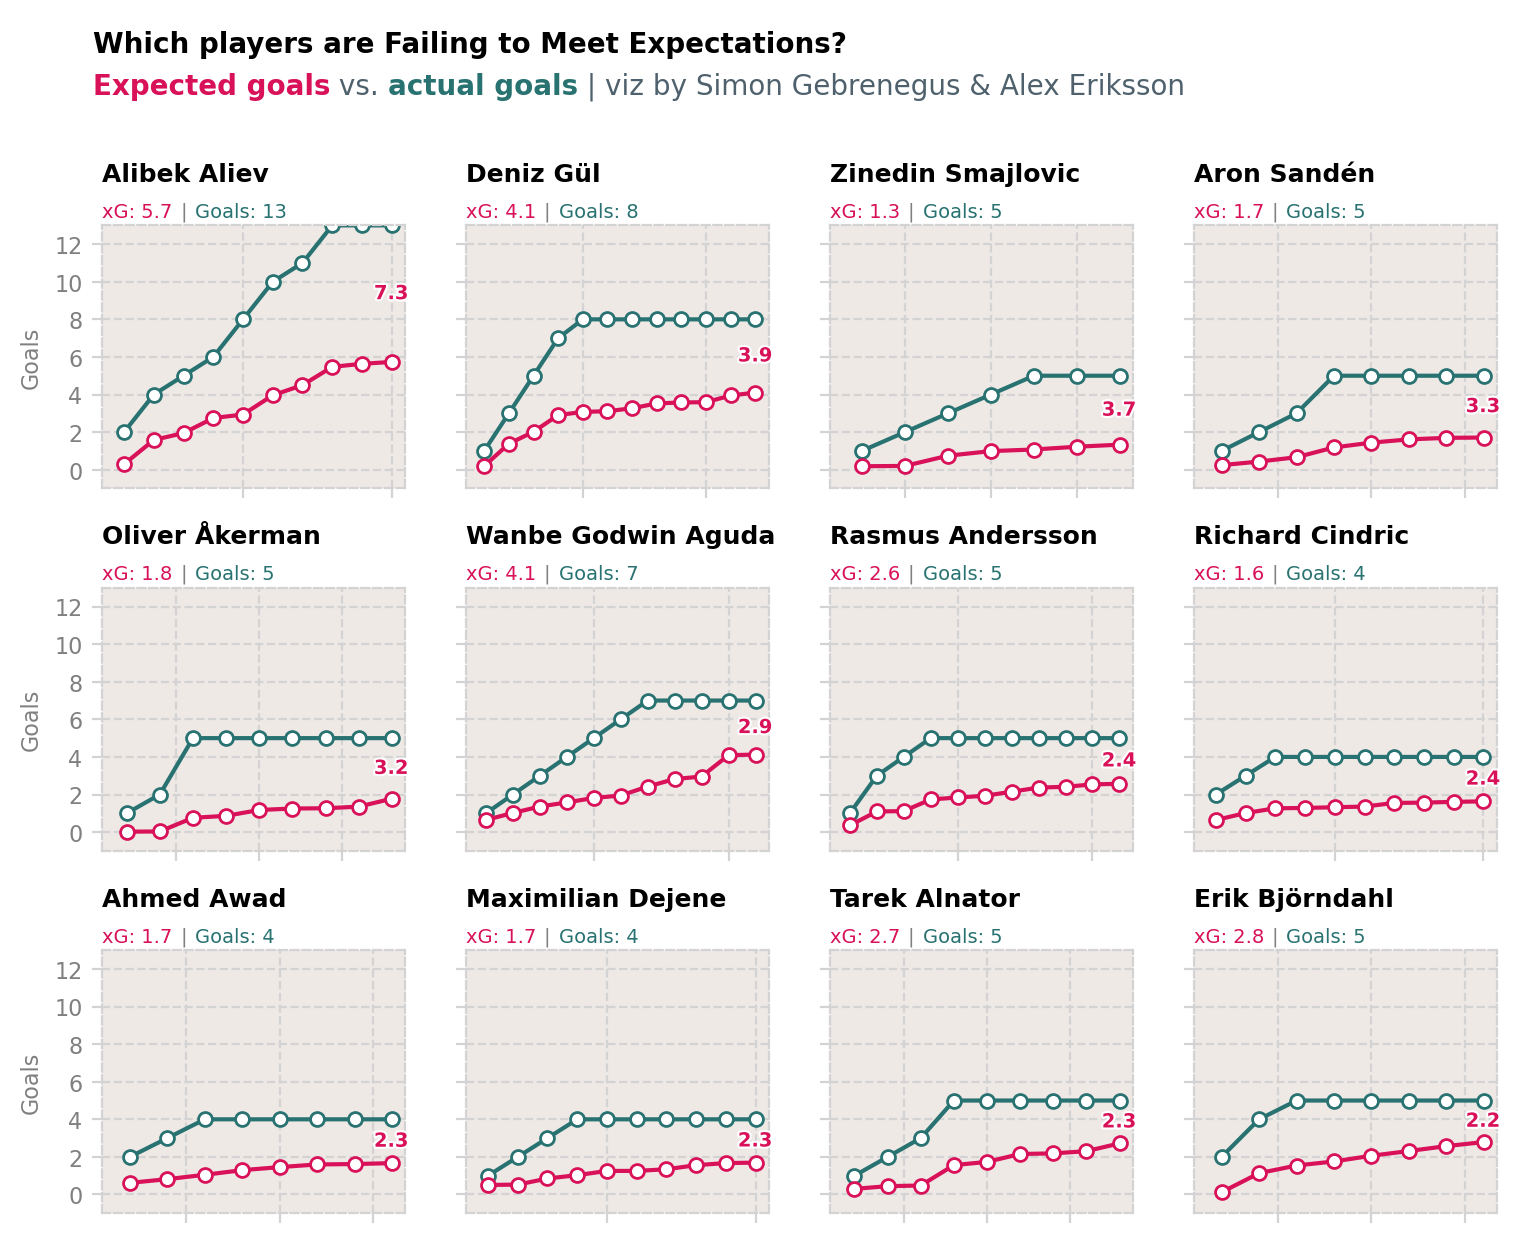

In [309]:
fig = plt.figure(figsize=(9, 7), dpi=200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1 / nrows) * 2.6 if x % 2 != 0 else (1 / nrows) / 2.6 for x in range(nrows)], hspace=0.2
)

# Choose the top 12 players based on the difference column in descending order
top_players = sum_diff_player_df.loc[(sum_diff_player_df['xG'] > 2) | (sum_diff_player_df['goals'] > 2)].nsmallest(12, 'difference')

# INSERT PLAYERS TO CHOOSE FROM LIST HERE
chosen_players = top_players['player'].tolist()

plot_counter = 0
name_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor="#EFE9E6"
            )
            if plot_counter < len(chosen_players):
                player = chosen_players[plot_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    label_y = col == 0
                    print(f"Plotting graph for {player} ({team})")
                    plot_goals_difference(ax, player, label_y, data=filtered_df)
                    plot_counter += 1
        else:
            if name_counter < len(chosen_players):
                player = chosen_players[name_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    xgoals = filtered_df.iloc[-1]['xG']
                    agoals = filtered_df.iloc[-1]['goals']
                    name_ax = plt.subplot(
                        gspec[row, col],
                        anchor='NW', facecolor='#EFE9E6'
                    )
                    name_ax.axis('off')

                    cumulative_xg = filtered_df['xG'].sum()
                    cumulative_goals = filtered_df['goals'].sum()
                    print(f"Cumulative xG for {player}: {cumulative_xg:.1f}")
                    print(f"Cumulative goals for {player}: {cumulative_goals:.0f}")
                    
                    ax_text(
                        x=0,  # Adjust this value to position the text closer to the graph
                        y=0.85,
                        s=f'<{player}>\n<xG: {cumulative_xg:.1f}> <|> <Goals: {cumulative_goals:.0f}>',
                        ax=name_ax,
                        highlight_textprops=[{'weight': 'bold', 'font': 'DM Sans'},
                                             {'size': '7', 'color': '#D81159'},
                                             {'size': '7', 'color': 'grey'},
                                             {'size': '7', 'color': '#287271'}],
                        font='Karla',
                        ha='left',
                        size=9,
                        annotationbbox_kw={'xycoords': 'axes fraction'}
                    )
                    name_counter += 1

fig_text(
    x=0.12, y=.95,
    s='Which players are Failing to Meet Expectations?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
    x=0.12, y=.92,
    s='<Expected goals> vs. <actual goals> | viz by Simon Gebrenegus & Alex Eriksson',
    highlight_textprops=[{'weight': 'bold', 'color': '#D81159'}, {'weight': 'bold', 'color': '#287271'}],
    va='bottom', ha='left',
    fontsize=8, color='#4E616C', font='Karla'
)

plt.show()


# xG > goals | more than 2 goals scored or more than 2 xG

Cumulative xG for Majkel Bagir: 5.8
Cumulative goals for Majkel Bagir: 3
Cumulative xG for Nobel Tesfazgyi Gebrezgi: 2.1
Cumulative goals for Nobel Tesfazgyi Gebrezgi: 0
Cumulative xG for Hampus Stoltz: 2.9
Cumulative goals for Hampus Stoltz: 1
Cumulative xG for Ayomide Jibodu: 2.7
Cumulative goals for Ayomide Jibodu: 1
Plotting graph for Majkel Bagir (IFK Stocksund)
Plotting graph for Nobel Tesfazgyi Gebrezgi (Hammarby TFF Herrfotboll)
Plotting graph for Hampus Stoltz (Eskilsminne IF)
Plotting graph for Ayomide Jibodu (Oskarshamns AIK)
Cumulative xG for Isak Vural: 2.7
Cumulative goals for Isak Vural: 1
Cumulative xG for Christian Moses: 5.5
Cumulative goals for Christian Moses: 4
Cumulative xG for Johan Albin: 3.4
Cumulative goals for Johan Albin: 2
Cumulative xG for Victor Andersson: 2.4
Cumulative goals for Victor Andersson: 1
Plotting graph for Isak Vural (Hammarby TFF Herrfotboll)
Plotting graph for Christian Moses (Vasalund)
Plotting graph for Johan Albin (Eskilsminne IF)
Plotti

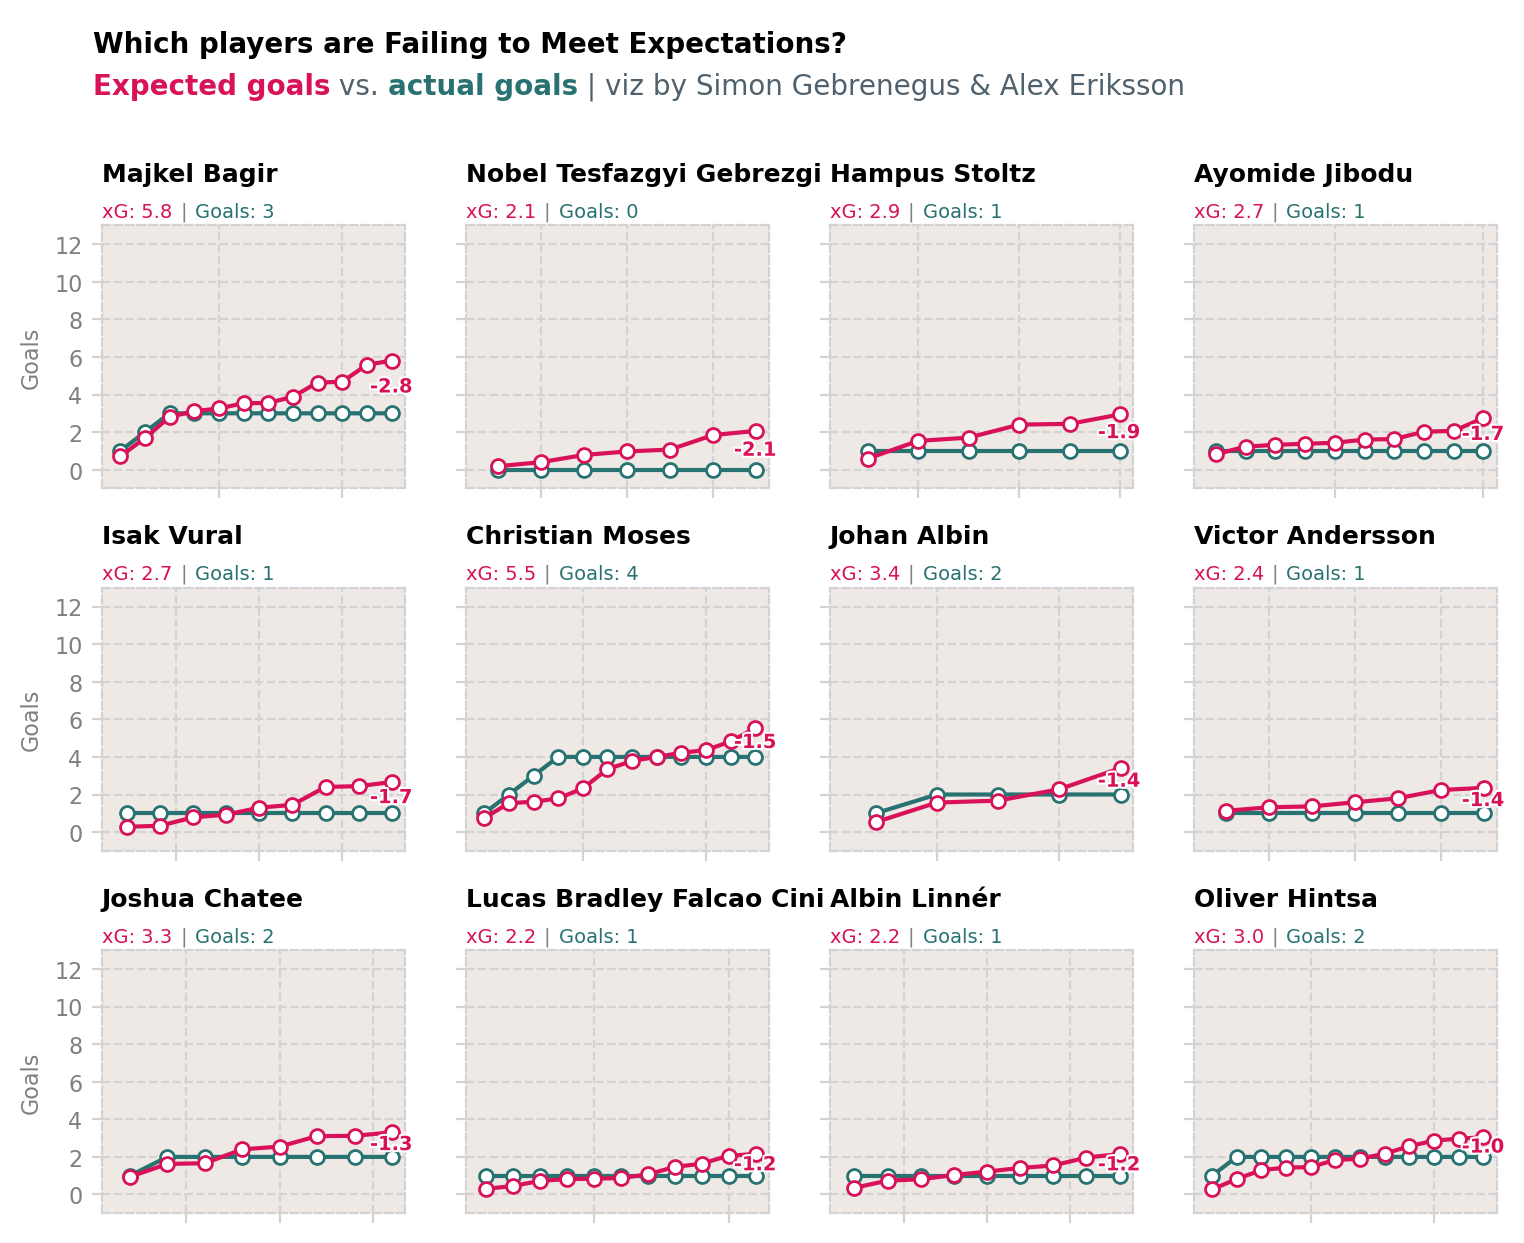

In [310]:
fig = plt.figure(figsize=(9, 7), dpi=200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1 / nrows) * 2.6 if x % 2 != 0 else (1 / nrows) / 2.6 for x in range(nrows)], hspace=0.2
)

# Choose the top 12 players based on the difference column in descending order
top_players = sum_diff_player_df.loc[(sum_diff_player_df['xG'] > 2) | (sum_diff_player_df['goals'] > 2)].nlargest(12, 'difference')

# INSERT PLAYERS TO CHOOSE FROM LIST HERE
chosen_players = top_players['player'].tolist()


plot_counter = 0
name_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor="#EFE9E6"
            )
            if plot_counter < len(chosen_players):
                player = chosen_players[plot_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    label_y = col == 0
                    print(f"Plotting graph for {player} ({team})")
                    plot_goals_difference(ax, player, label_y, data=filtered_df)
                    plot_counter += 1
        else:
            if name_counter < len(chosen_players):
                player = chosen_players[name_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    xgoals = filtered_df.iloc[-1]['xG']
                    agoals = filtered_df.iloc[-1]['goals']
                    name_ax = plt.subplot(
                        gspec[row, col],
                        anchor='NW', facecolor='#EFE9E6'
                    )
                    name_ax.axis('off')

                    cumulative_xg = filtered_df['xG'].sum()
                    cumulative_goals = filtered_df['goals'].sum()
                    print(f"Cumulative xG for {player}: {cumulative_xg:.1f}")
                    print(f"Cumulative goals for {player}: {cumulative_goals:.0f}")
                    
                    ax_text(
                        x=0,  # Adjust this value to position the text closer to the graph
                        y=0.85,
                        s=f'<{player}>\n<xG: {cumulative_xg:.1f}> <|> <Goals: {cumulative_goals:.0f}>',
                        ax=name_ax,
                        highlight_textprops=[{'weight': 'bold', 'font': 'DM Sans'},
                                             {'size': '7', 'color': '#D81159'},
                                             {'size': '7', 'color': 'grey'},
                                             {'size': '7', 'color': '#287271'}],
                        font='Karla',
                        ha='left',
                        size=9,
                        annotationbbox_kw={'xycoords': 'axes fraction'}
                    )
                    name_counter += 1

fig_text(
    x=0.12, y=.95,
    s='Which players are Failing to Meet Expectations?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
    x=0.12, y=.92,
    s='<Expected goals> vs. <actual goals> | viz by Simon Gebrenegus & Alex Eriksson',
    highlight_textprops=[{'weight': 'bold', 'color': '#D81159'}, {'weight': 'bold', 'color': '#287271'}],
    va='bottom', ha='left',
    fontsize=8, color='#4E616C', font='Karla'
)

plt.show()


# Example code if we want to handle long names with "..." in the end?

Cumulative xG for Majkel Bagir: 5.8
Cumulative goals for Majkel Bagir: 3
Cumulative xG for Nobel Tesfazgyi Gebrezgi: 2.1
Cumulative goals for Nobel Tesfazgyi Gebrezgi: 0
Cumulative xG for Hampus Stoltz: 2.9
Cumulative goals for Hampus Stoltz: 1
Cumulative xG for Hampus Ferhm: 1.9
Cumulative goals for Hampus Ferhm: 0
Plotting graph for Majkel Bagir (IFK Stocksund)
Plotting graph for Nobel Tesfazgyi Gebrezgi (Hammarby TFF Herrfotboll)
Plotting graph for Hampus Stoltz (Eskilsminne IF)
Plotting graph for Hampus Ferhm (Torns IF)
Cumulative xG for Nicolas Gianini Dantas: 1.8
Cumulative goals for Nicolas Gianini Dantas: 0
Cumulative xG for Declan Watters: 1.8
Cumulative goals for Declan Watters: 0
Cumulative xG for Ayomide Jibodu: 2.7
Cumulative goals for Ayomide Jibodu: 1
Cumulative xG for Max Andersson: 1.7
Cumulative goals for Max Andersson: 0
Plotting graph for Nicolas Gianini Dantas (Oskarshamns AIK)
Plotting graph for Declan Watters (Vänersborgs IF)
Plotting graph for Ayomide Jibodu (Os

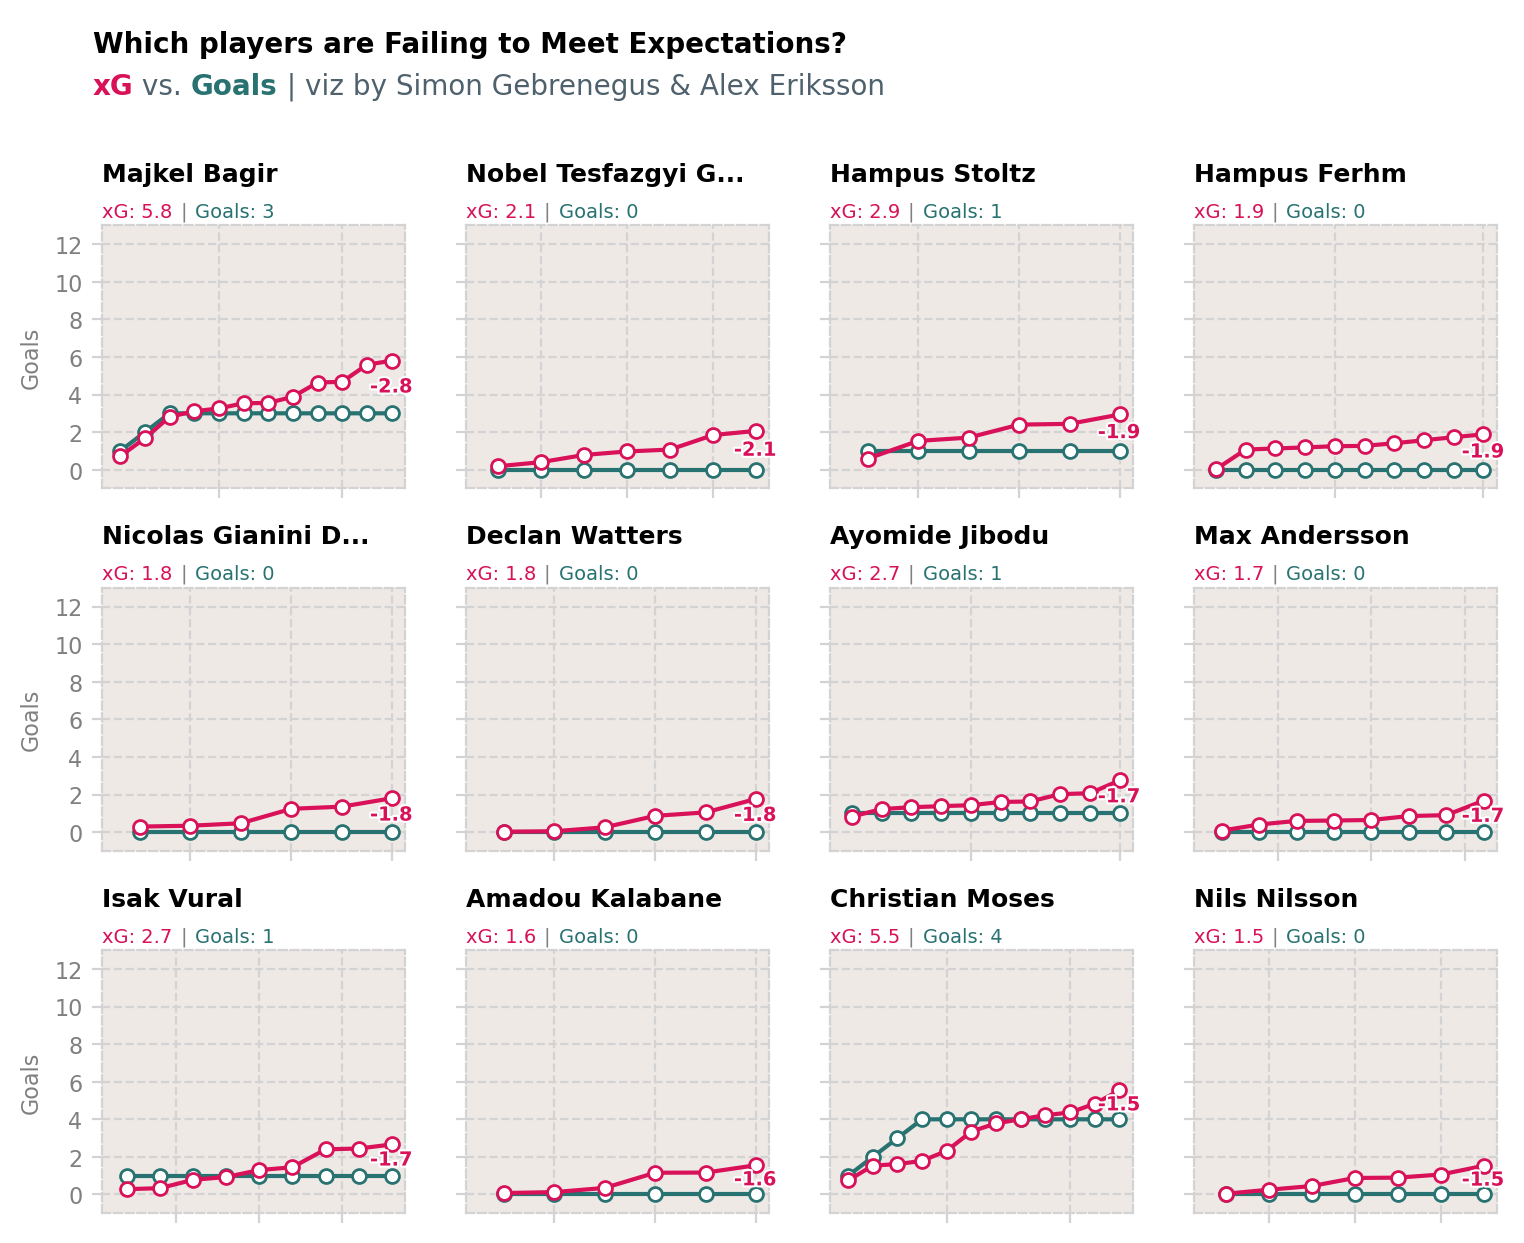

In [311]:
fig = plt.figure(figsize=(9, 7), dpi=200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1 / nrows) * 2.6 if x % 2 != 0 else (1 / nrows) / 2.6 for x in range(nrows)], hspace=0.2
)

# Choose the top 12 players based on the difference column
top_players = sum_diff_player_df.nlargest(12, 'difference')

# INSERT PLAYERS TO CHOOSE FROM LIST HERE
chosen_players = top_players['player'].tolist()

plot_counter = 0
name_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor="#EFE9E6"
            )
            if plot_counter < len(chosen_players):
                player = chosen_players[plot_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    label_y = col == 0
                    print(f"Plotting graph for {player} ({team})")
                    plot_goals_difference(ax, player, label_y, data=filtered_df)
                    plot_counter += 1
        else:
            if name_counter < len(chosen_players):
                player = chosen_players[name_counter]
                filtered_df = player_df[player_df['player'] == player]
                if not filtered_df.empty:
                    team = filtered_df.iloc[0]['team']
                    xgoals = filtered_df.iloc[-1]['xG']
                    agoals = filtered_df.iloc[-1]['goals']
                    name_ax = plt.subplot(
                        gspec[row, col],
                        anchor='NW', facecolor='#EFE9E6'
                    )
                    name_ax.axis('off')

                    # -- Add player name (truncate if too long)
                    max_name_length = 17
                    if not filtered_df.empty:
                        truncated_player = player[:max_name_length] + '...' if len(player) > max_name_length else player

                        cumulative_xg = filtered_df['xG'].sum()
                        cumulative_goals = filtered_df['goals'].sum()
                        print(f"Cumulative xG for {player}: {cumulative_xg:.1f}")
                        print(f"Cumulative goals for {player}: {cumulative_goals:.0f}")

                        ax_text(
                            x=0,  # Adjust this value to position the text closer to the graph
                            y=0.85,
                            s=f'<{truncated_player}>\n<xG: {cumulative_xg:.1f}> <|> <Goals: {cumulative_goals:.0f}>',
                            ax=name_ax,
                            highlight_textprops=[{'weight': 'bold', 'font': 'DM Sans'},
                                                 {'size': '7', 'color': '#D81159'},
                                                 {'size': '7', 'color': 'grey'},
                                                 {'size': '7', 'color': '#287271'}],
                            font='Karla',
                            ha='left',
                            size=9,
                            annotationbbox_kw={'xycoords': 'axes fraction'}
                        )
                        name_counter += 1
                    

fig_text(
    x=0.12, y=.95,
    s='Which players are Failing to Meet Expectations?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
    x=0.12, y=.92,
    s='<xG> vs. <Goals> | viz by Simon Gebrenegus & Alex Eriksson',
    highlight_textprops=[{'weight': 'bold', 'color': '#D81159'}, {'weight': 'bold', 'color': '#287271'}],
    va='bottom', ha='left',
    fontsize=8, color='#4E616C', font='Karla'
)

plt.show()
